In [284]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [285]:
# Download historical Bitcoin data using yfinance
bitcoin_data = yf.download('BTC-USD', start='2010-01-01', end='2023-01-01')

[*********************100%%**********************]  1 of 1 completed


Data exploration

In [286]:
# Display basic information about the data
print(bitcoin_data.info())
print(bitcoin_data.describe())

# Check for missing values
print("Missing values:\n", bitcoin_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3028 entries, 2014-09-17 to 2022-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3028 non-null   float64
 1   High       3028 non-null   float64
 2   Low        3028 non-null   float64
 3   Close      3028 non-null   float64
 4   Adj Close  3028 non-null   float64
 5   Volume     3028 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 165.6 KB
None
               Open          High           Low         Close     Adj Close  \
count   3028.000000   3028.000000   3028.000000   3028.000000   3028.000000   
mean   12858.370058  13182.567711  12495.418710  12862.178425  12862.178425   
std    16190.316636  16604.605750  15710.663914  16185.351172  16185.351172   
min      176.897003    211.731003    171.509995    178.102997    178.102997   
25%      672.789017    684.548492    663.220993    675.556259    675.556259   
50%     7097.275635   728

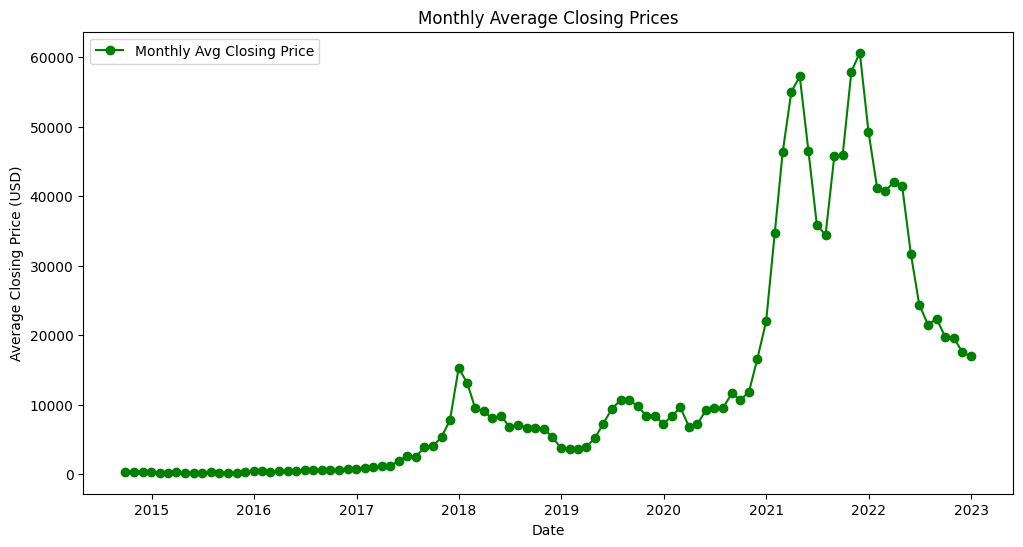

In [287]:
# Monthly average closing prices
monthly_avg = bitcoin_data['Close'].resample('M').mean()
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg, marker='o', linestyle='-', color='green', label='Monthly Avg Closing Price')
plt.title('Monthly Average Closing Prices')
plt.xlabel('Date')
plt.ylabel('Average Closing Price (USD)')
plt.legend()
plt.show()

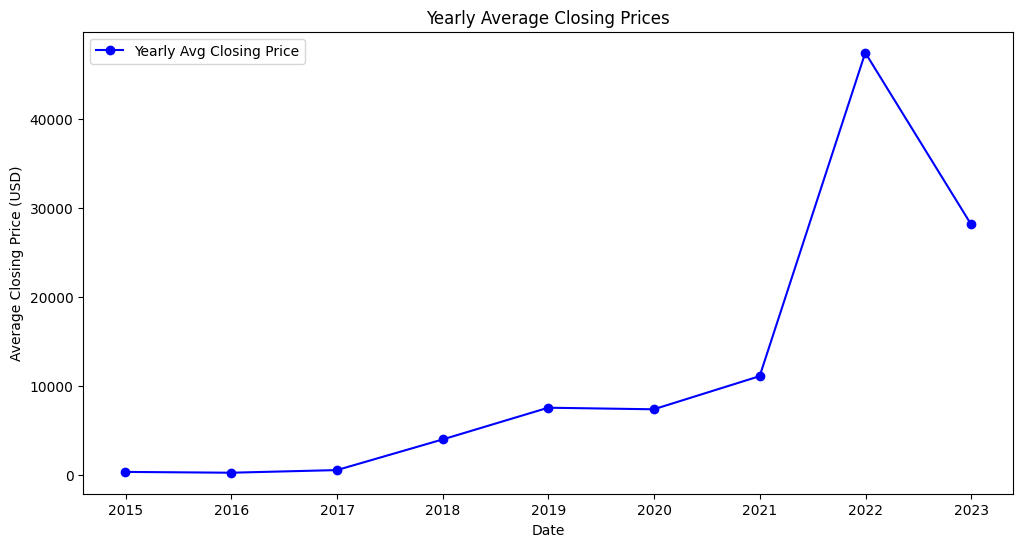

In [288]:
# Yearly average closing prices
yearly_avg = bitcoin_data['Close'].resample('Y').mean()
plt.figure(figsize=(12, 6))
plt.plot(yearly_avg, marker='o', linestyle='-', color='blue', label='Yearly Avg Closing Price')
plt.title('Yearly Average Closing Prices')
plt.xlabel('Date')
plt.ylabel('Average Closing Price (USD)')
plt.legend()
plt.show()

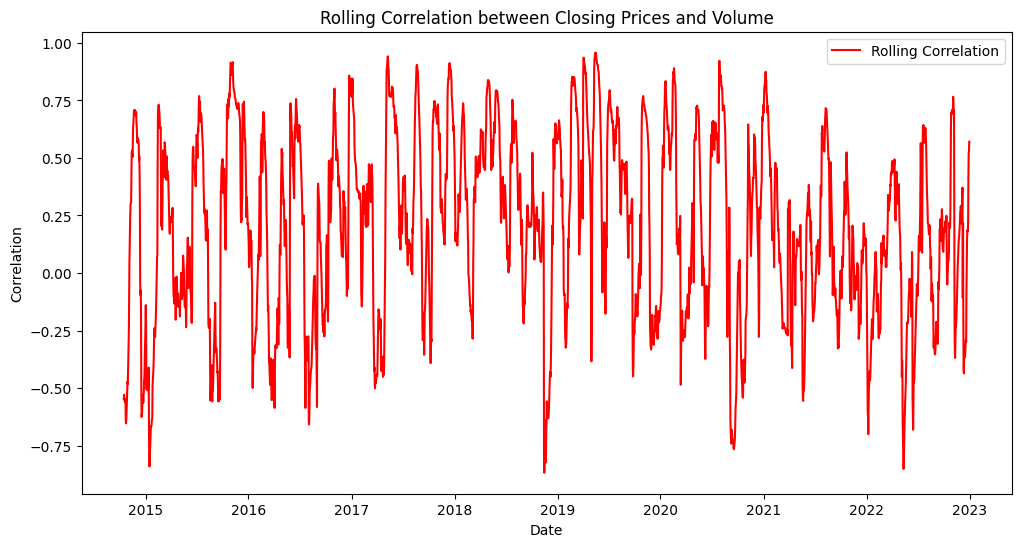

In [289]:
# Rolling correlation between closing prices and volume
rolling_corr = bitcoin_data['Close'].rolling(window=30).corr(bitcoin_data['Volume'])
plt.figure(figsize=(12, 6))
plt.plot(rolling_corr, label='Rolling Correlation', color='red')
plt.title('Rolling Correlation between Closing Prices and Volume')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.show()

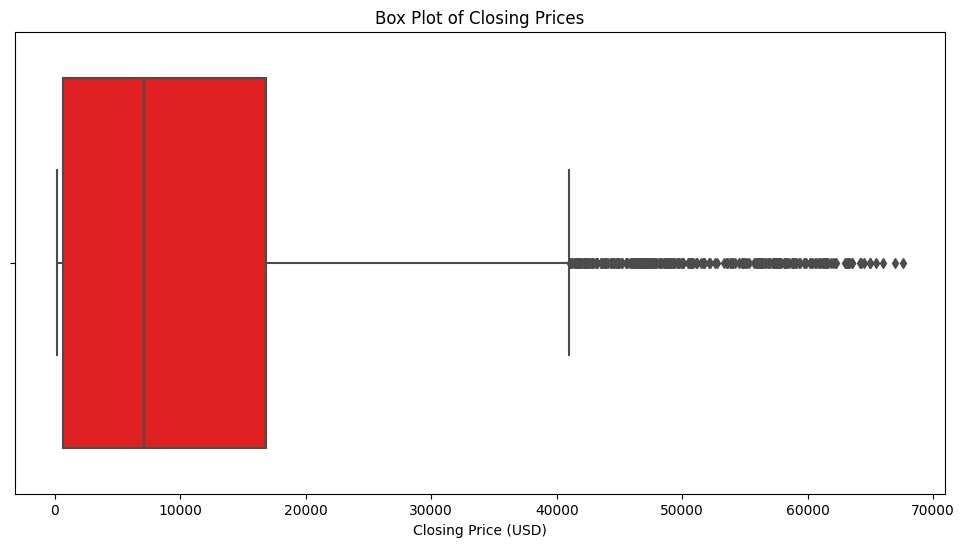

In [290]:
# Box plot for closing prices
plt.figure(figsize=(12, 6))
sns.boxplot(x=bitcoin_data['Close'], color='red')
plt.title('Box Plot of Closing Prices')
plt.xlabel('Closing Price (USD)')
plt.show()

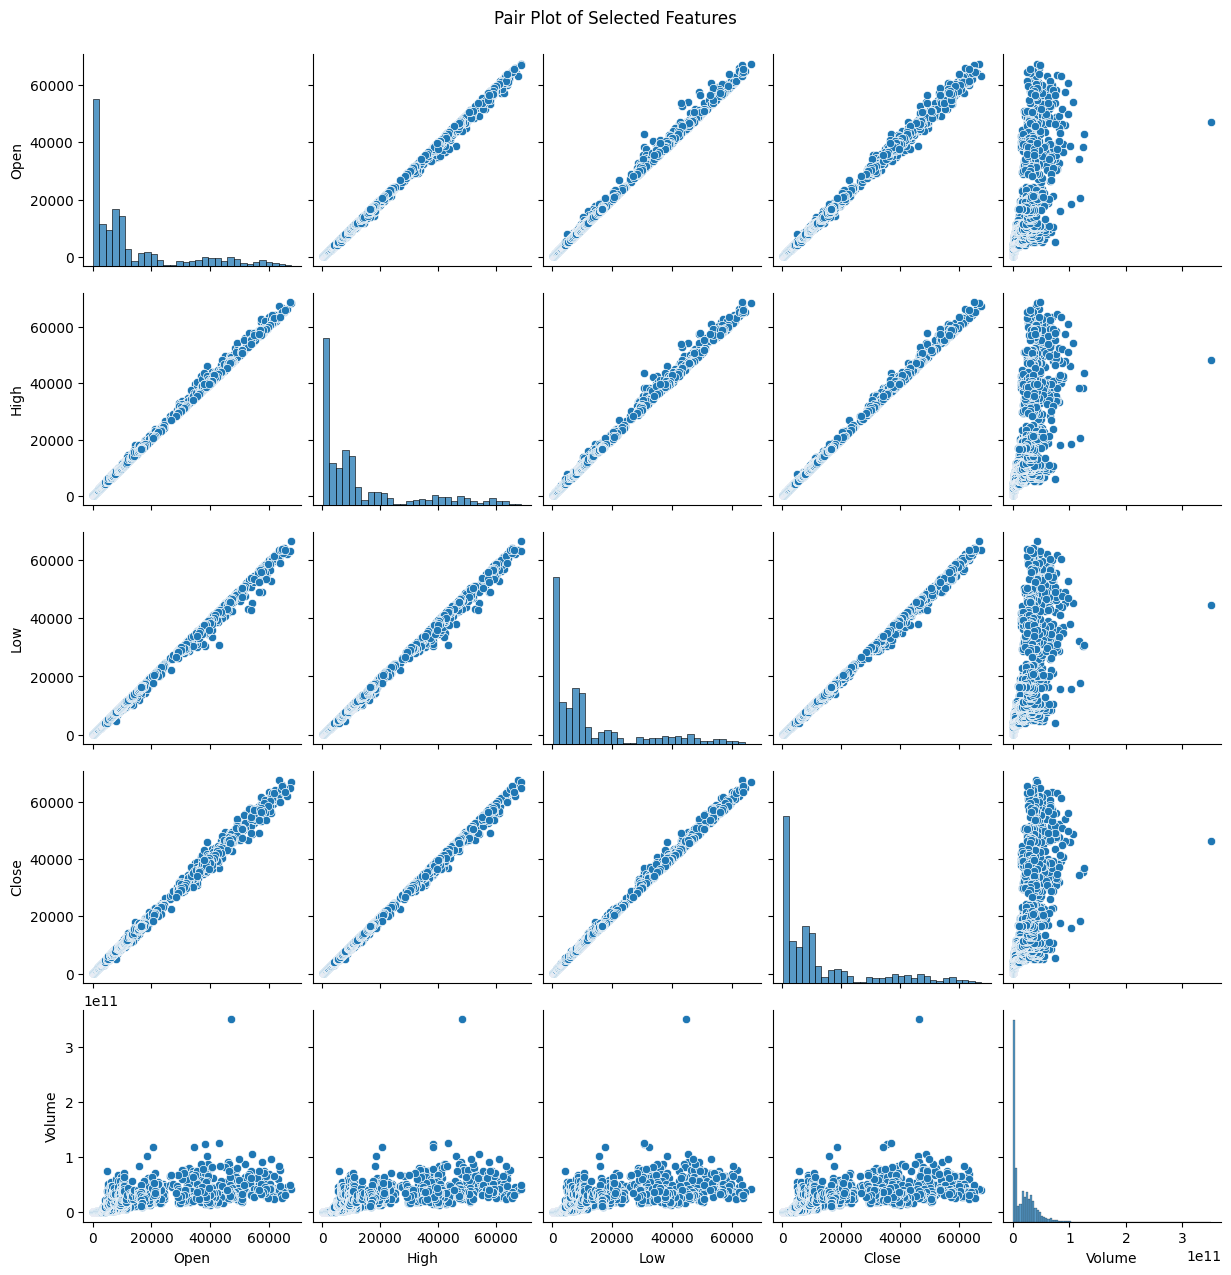

In [291]:
# Pair plot for selected features
selected_features = ['Open', 'High', 'Low', 'Close', 'Volume']
sns.pairplot(bitcoin_data[selected_features])
plt.suptitle('Pair Plot of Selected Features', y=1.02)
plt.show()

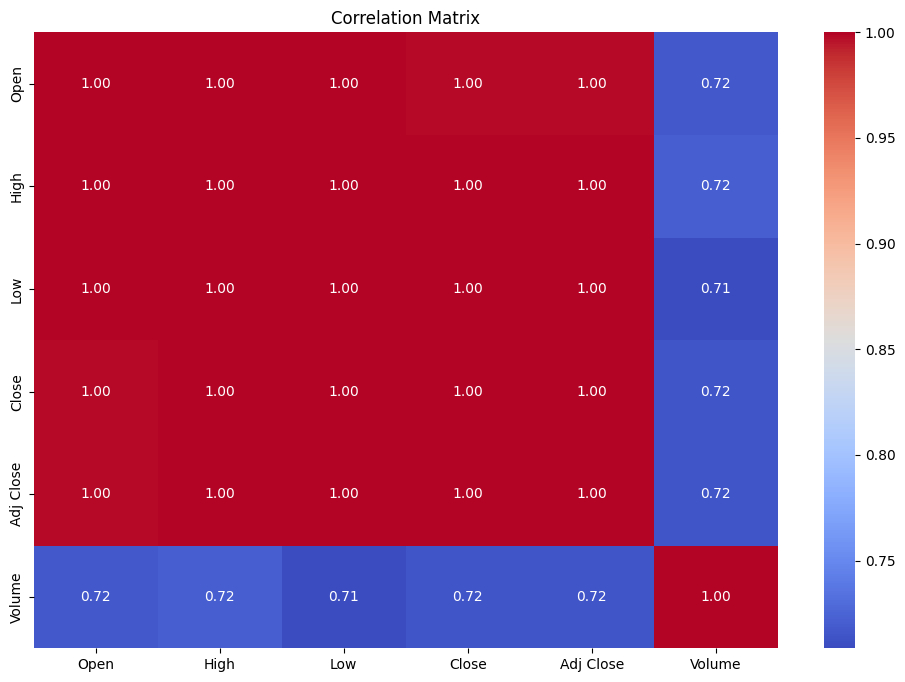

In [292]:
# Heatmap for correlation matrix
correlation_matrix = bitcoin_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [293]:
# Candlestick chart
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=bitcoin_data.index,
                open=bitcoin_data['Open'],
                high=bitcoin_data['High'],
                low=bitcoin_data['Low'],
                close=bitcoin_data['Close'])])

fig.update_layout(title='Bitcoin Candlestick Chart',
                  xaxis_title='Date',
                  yaxis_title='Bitcoin Price (USD)')
fig.show()

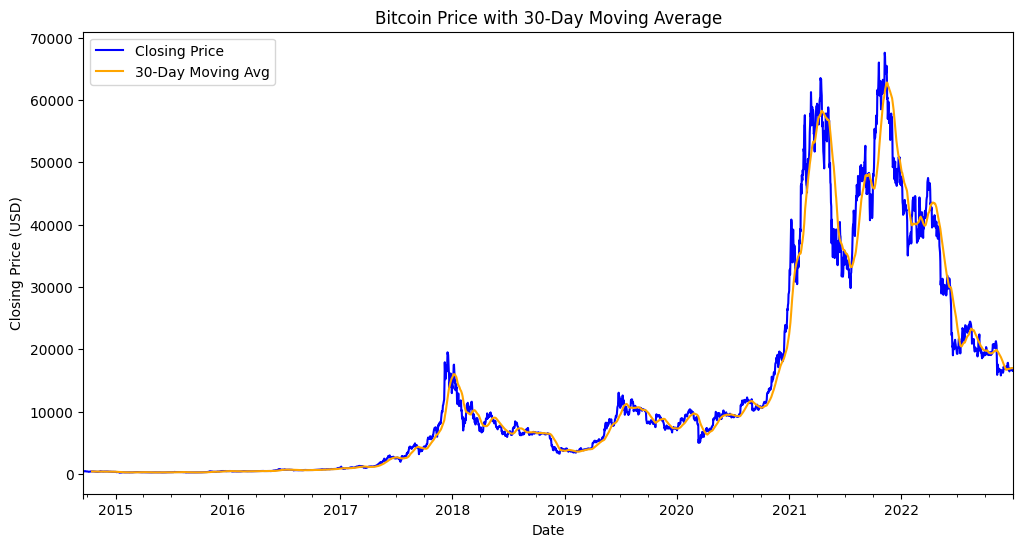

In [294]:
# Trend analysis using a moving average
plt.figure(figsize=(12, 6))
bitcoin_data['Close'].plot(label='Closing Price', color='blue')
bitcoin_data['Close'].rolling(window=30).mean().plot(label='30-Day Moving Avg', color='orange')
plt.title('Bitcoin Price with 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.show()

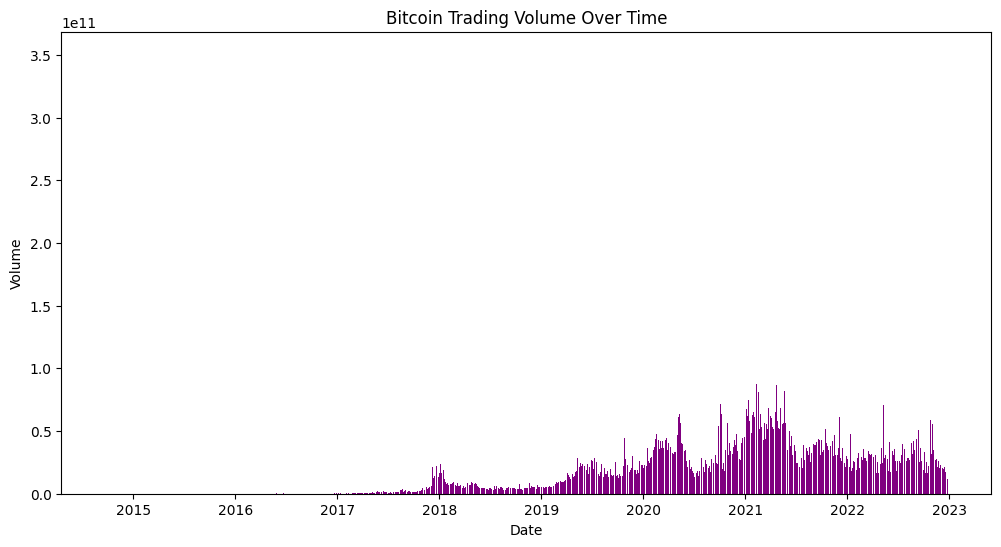

In [295]:
# Volume analysis with a bar chart
plt.figure(figsize=(12, 6))
plt.bar(bitcoin_data.index, bitcoin_data['Volume'], color='purple')
plt.title('Bitcoin Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

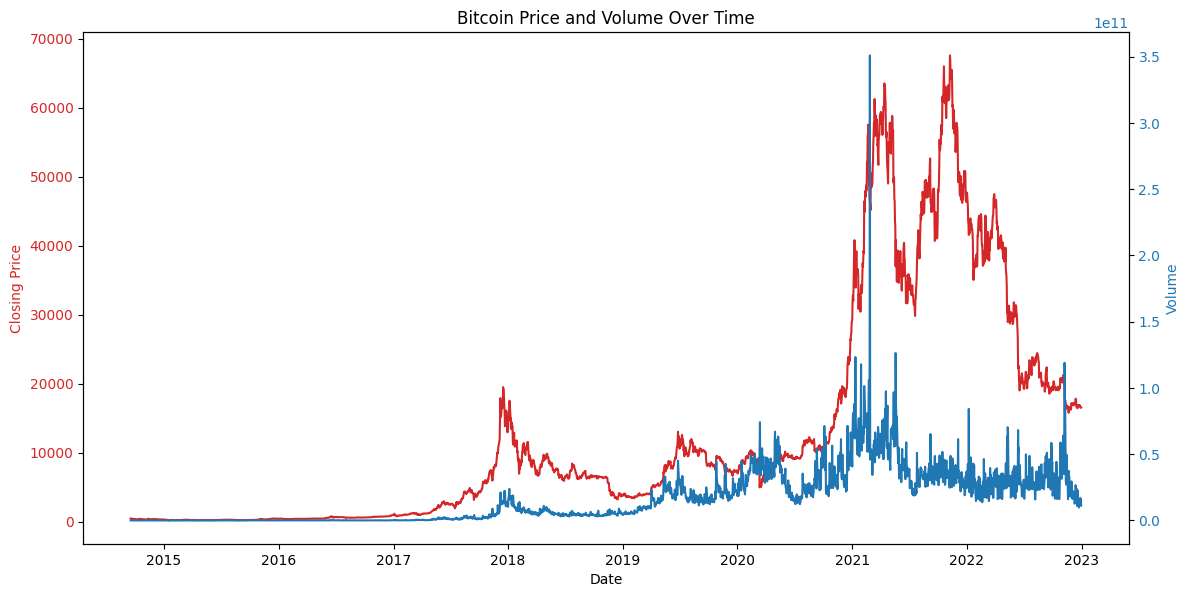

In [296]:
# Price and Volume Line Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Price', color=color)
ax1.plot(bitcoin_data.index, bitcoin_data['Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Volume', color=color)
ax2.plot(bitcoin_data.index, bitcoin_data['Volume'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Bitcoin Price and Volume Over Time')
plt.show()

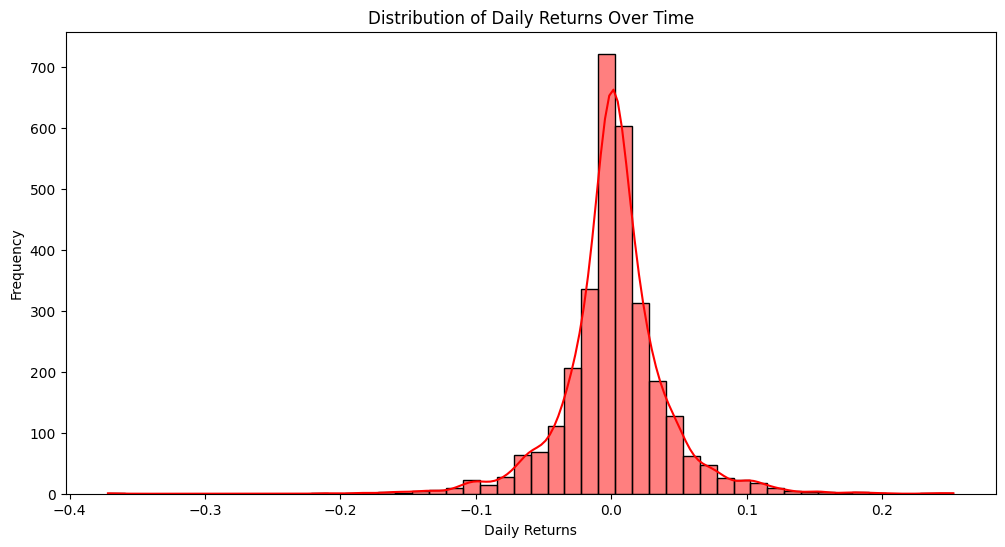

In [297]:
# Return Distribution Over Time
daily_returns = bitcoin_data['Close'].pct_change()
plt.figure(figsize=(12, 6))
sns.histplot(daily_returns.dropna(), bins=50, kde=True, color='red')
plt.title('Distribution of Daily Returns Over Time')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.show()

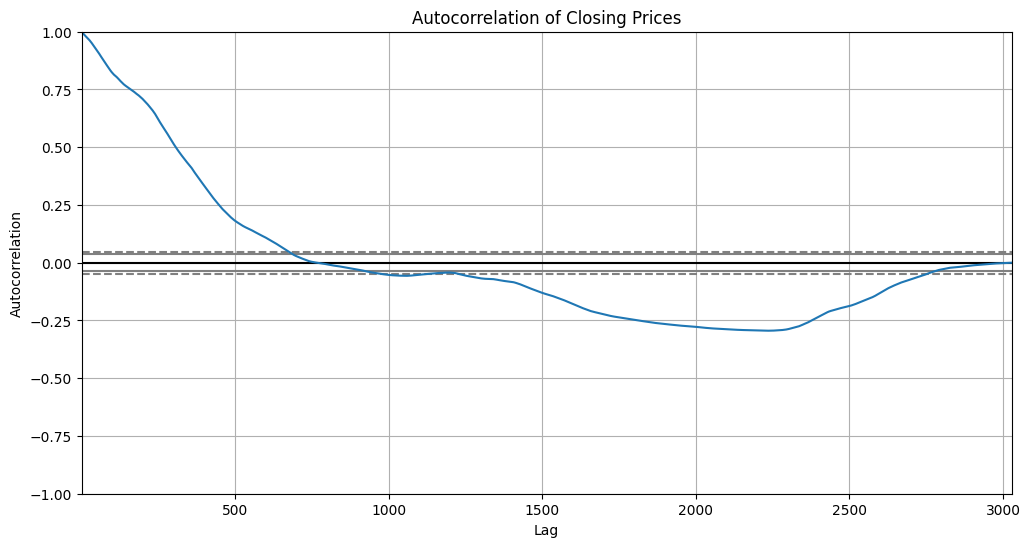

In [298]:
# Autocorrelation Plot
plt.figure(figsize=(12, 6))
pd.plotting.autocorrelation_plot(bitcoin_data['Close'])
plt.title('Autocorrelation of Closing Prices')
plt.xlabel('Lag')
plt.show()

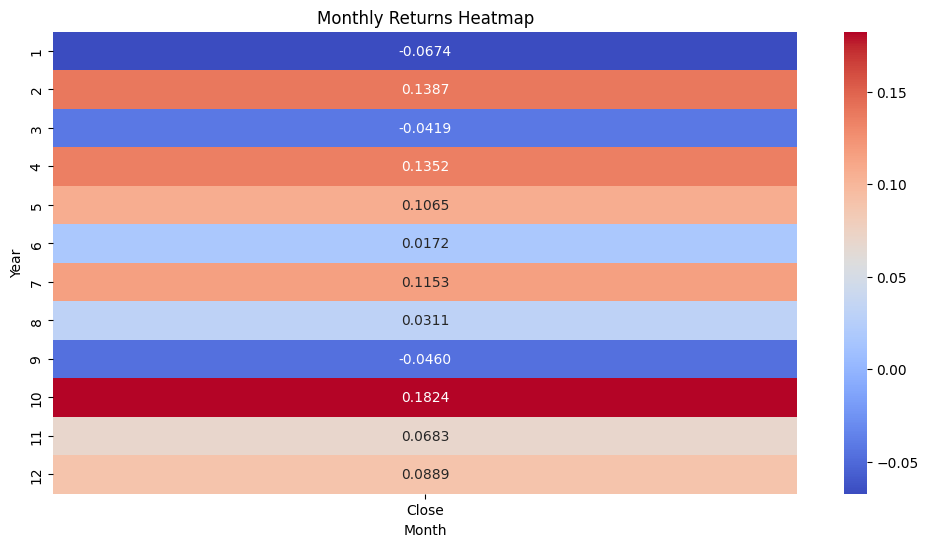

In [299]:
# Monthly Returns Heatmap
monthly_returns = bitcoin_data['Close'].resample('M').ffill().pct_change()
monthly_returns = monthly_returns[1:]  # Remove NaN value from the first row
monthly_returns = monthly_returns.groupby(monthly_returns.index.month).mean()

plt.figure(figsize=(12, 6))
sns.heatmap(monthly_returns.to_frame(), cmap='coolwarm', annot=True, fmt=".4f")
plt.title('Monthly Returns Heatmap')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

Data preprocessing

In [300]:
# Handle missing values
bitcoin_data.dropna(inplace=True)

# Feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(bitcoin_data['Close'].values.reshape(-1, 1))

# Create training data
training_data_len = int(np.ceil(len(scaled_data) * .95))
train_data = scaled_data[0:int(training_data_len), :]

# Create the scaled training data set
x_train, y_train = [], []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Display the shape of the training data
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of x_train: (2817, 60, 1)
Shape of y_train: (2817,)


Create the model

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 60, 50)            10400     
                                                                 
 lstm_18 (LSTM)              (None, 50)                20200     
                                                                 
 dense_17 (Dense)            (None, 25)                1275      
                                                                 
 dense_18 (Dense)            (None, 1)                 26        
                                                                 
Total params: 31901 (124.61 KB)
Trainable params: 31901 (124.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
5/5 [==============================] - 1s 20ms/step
Root Mean Squared Error (RMSE): 1361.7592353062914


<ipython-input-301-6abb35e013e2>:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



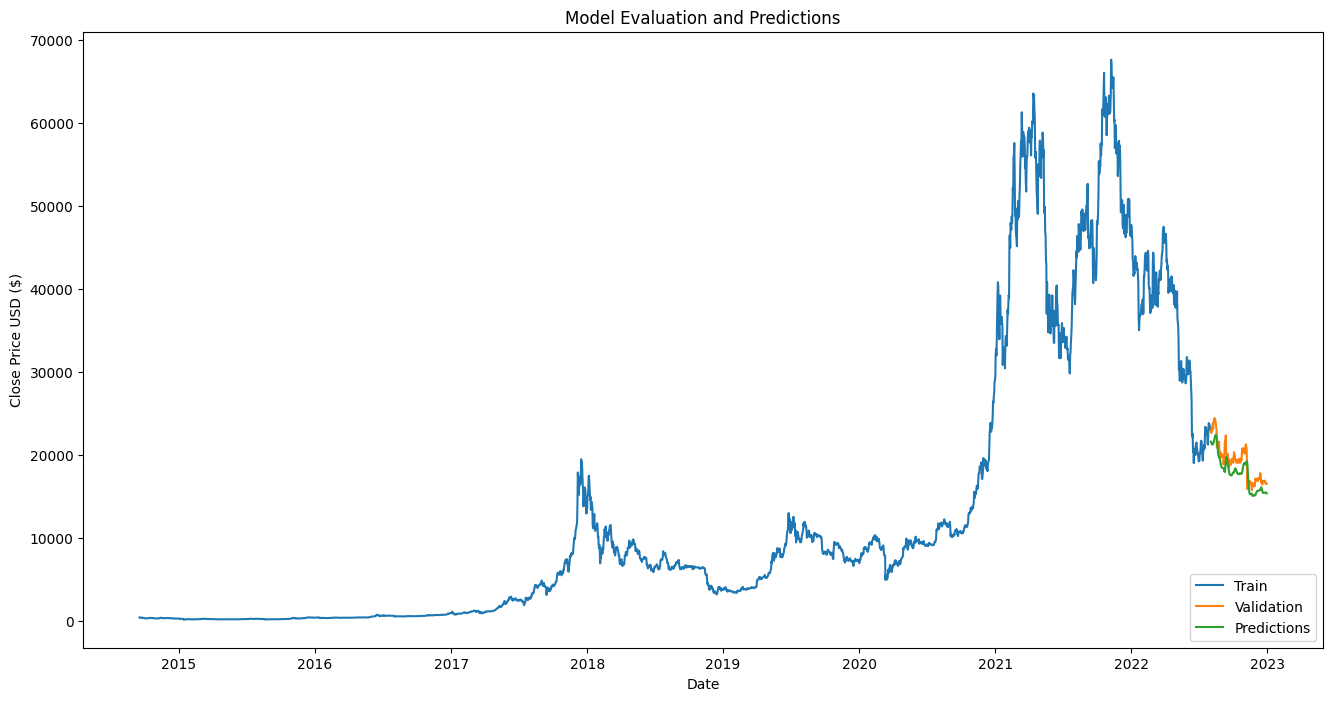

In [301]:
# Build the LSTM model
model = Sequential()

# Add the first LSTM layer with input shape (60, 1)
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model.summary()

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Test data set
test_data = scaled_data[training_data_len - 60:, :]

# Create the x_test and y_test data sets
x_test = []
y_test = bitcoin_data['Close'][training_data_len:].values

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the model predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Evaluate the model
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Plot the data
train = bitcoin_data[:training_data_len]
valid = bitcoin_data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16, 8))
plt.title('Model Evaluation and Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')

# Plotting training data
plt.plot(train['Close'], label='Train')

# Plotting validation data and predictions
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Validation', 'Predictions'], loc='lower right')
plt.show()


Evaluate the model

In [302]:
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
r2 = r2_score(y_test, predictions)

print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'R-squared (R2) Score: {r2:.4f}')

Root Mean Squared Error (RMSE): 1558.2442244327383
Mean Absolute Error (MAE): 1431.9436956746688
Mean Absolute Percentage Error (MAPE): 13.53%
R-squared (R2) Score: 0.5011


Plot the data

<ipython-input-303-892af10c2fe4>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



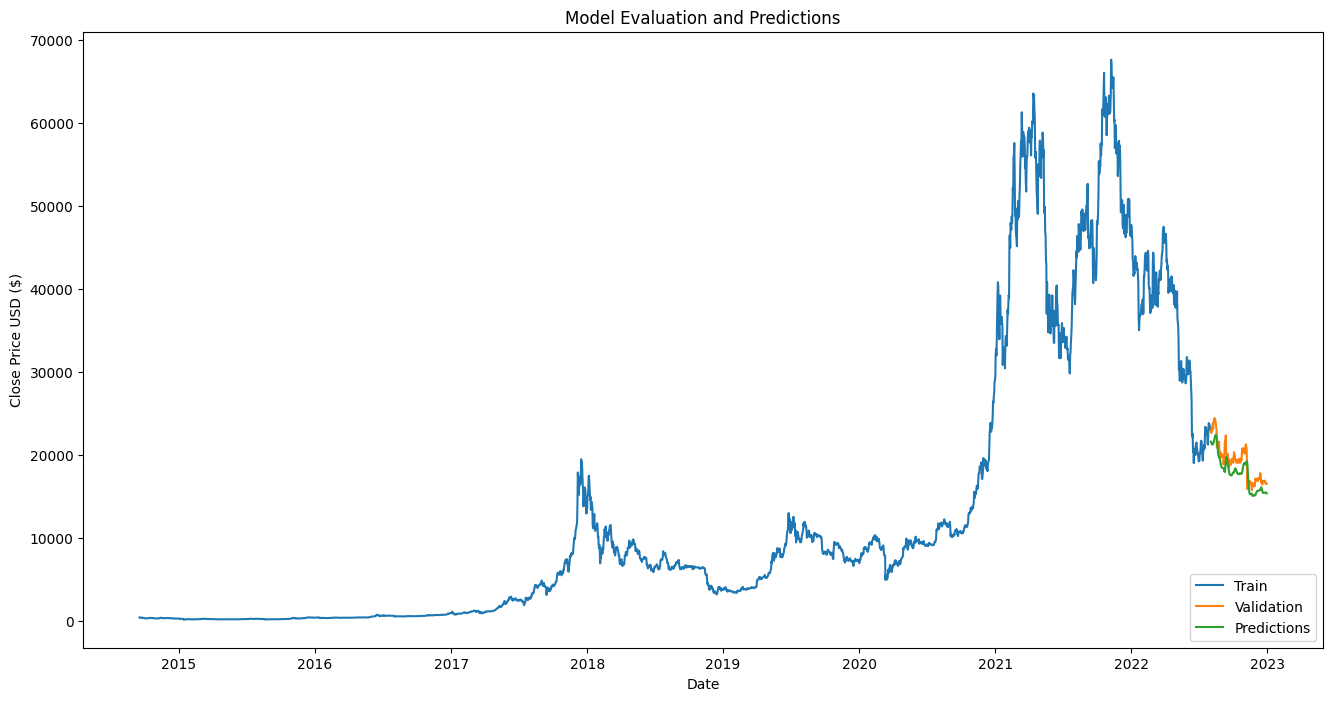

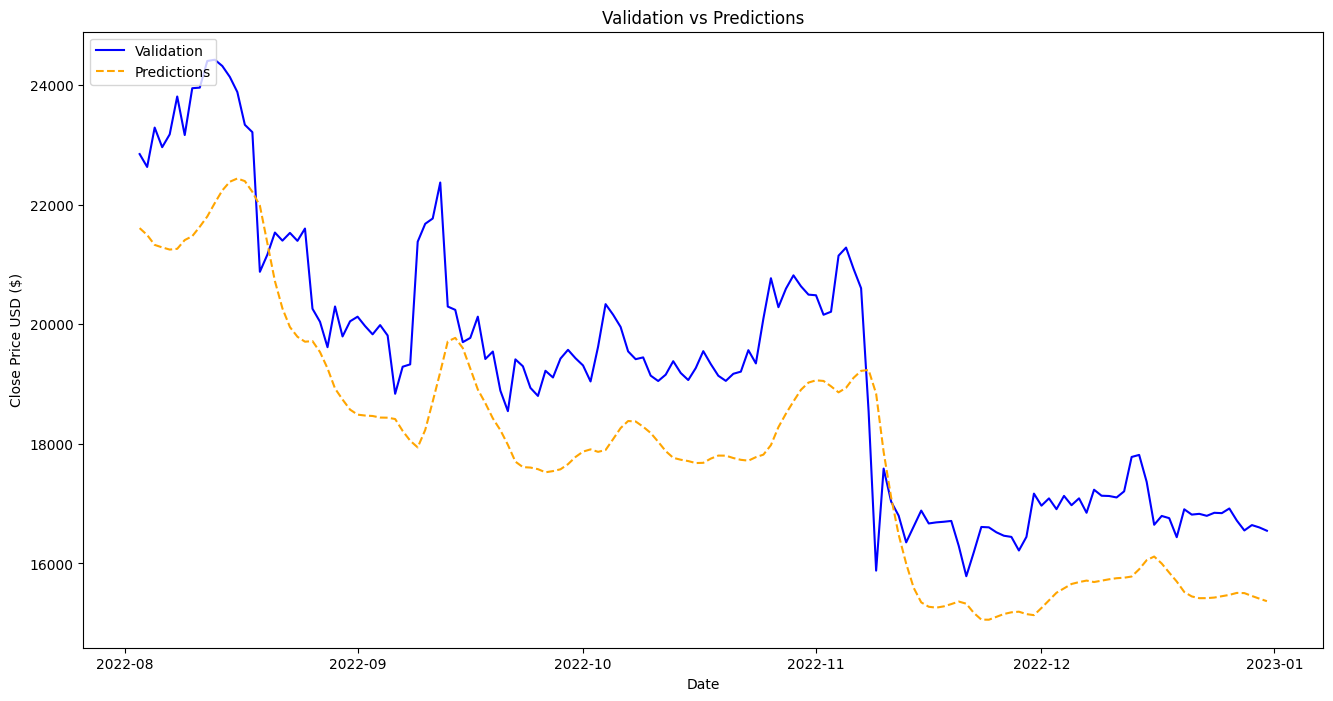

In [303]:
train = bitcoin_data[:training_data_len]
valid = bitcoin_data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16, 8))
plt.title('Model Evaluation and Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')

# Plotting training data
plt.plot(train['Close'], label='Train')

# Plotting validation data and predictions
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Validation', 'Predictions'], loc='lower right')
plt.show()

# Plotting validation data and predictions separately
plt.figure(figsize=(16, 8))
plt.title('Validation vs Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')

# Plotting validation data
plt.plot(valid['Close'], label='Validation', color='blue')

# Plotting predicted prices
plt.plot(valid['Predictions'], label='Predictions', linestyle='dashed', color='orange')

plt.legend(loc='upper left')
plt.show()

Predicting Bitcoin Price

In [304]:
# Number of future days to predict
future_days = 90

# Create a copy of the last 90 days of the scaled data to generate future predictions
future_data = scaled_data[-90:, :].copy()

# Generate predictions for the next 'future_days'
for i in range(future_days):
    x_future = future_data[-90:].reshape((1, 90, 1))
    prediction = model.predict(x_future)
    future_data = np.append(future_data, prediction, axis=0)

# Inverse transform the scaled data to get actual price values
future_predictions = scaler.inverse_transform(future_data[-future_days:].reshape(-1, 1))

1/1 [==============================] - 0s 33ms/step


In [305]:
# Create future dates for the x-axis
future_dates = pd.date_range(bitcoin_data.index[-1], periods=future_days + 1, freq='B')[1:]

# Display the predicted values for future days
print("Predicted Bitcoin Prices for Future Days:")
for date, price in zip(future_dates, future_predictions):
    print(f"{date.date()}: ${price[0]:.2f}")

Predicted Bitcoin Prices for Future Days:
2023-01-03: $15326.45
2023-01-04: $15079.92
2023-01-05: $14742.14
2023-01-06: $14364.73
2023-01-09: $13972.71
2023-01-10: $13578.54
2023-01-11: $13188.56
2023-01-12: $12806.05
2023-01-13: $12432.66
2023-01-16: $12069.12
2023-01-17: $11715.64
2023-01-18: $11372.09
2023-01-19: $11038.12
2023-01-20: $10713.31
2023-01-23: $10397.15
2023-01-24: $10089.14
2023-01-25: $9788.76
2023-01-26: $9495.55
2023-01-27: $9209.08
2023-01-30: $8928.97
2023-01-31: $8654.87
2023-02-01: $8386.49
2023-02-02: $8123.57
2023-02-03: $7865.90
2023-02-06: $7613.27
2023-02-07: $7365.53
2023-02-08: $7122.53
2023-02-09: $6884.14
2023-02-10: $6650.24
2023-02-13: $6420.74
2023-02-14: $6195.52
2023-02-15: $5974.51
2023-02-16: $5757.60
2023-02-17: $5544.73
2023-02-20: $5335.80
2023-02-21: $5130.74
2023-02-22: $4929.47
2023-02-23: $4731.91
2023-02-24: $4537.99
2023-02-27: $4347.63
2023-02-28: $4160.77
2023-03-01: $3977.32
2023-03-02: $3797.23
2023-03-03: $3620.42
2023-03-06: $3446.

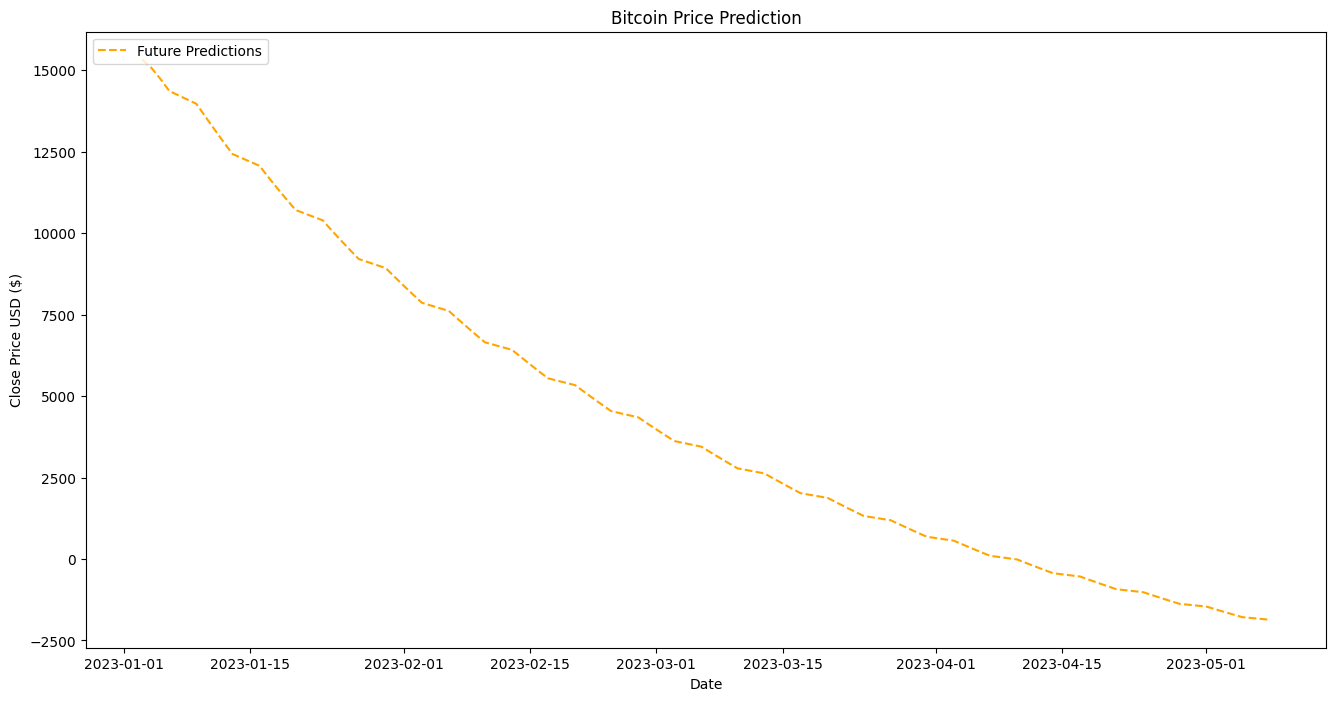

In [306]:
plt.figure(figsize=(16, 8))
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')

# Plotting future predictions
plt.plot(future_dates, future_predictions, label='Future Predictions', linestyle='dashed', color='orange')

plt.legend(loc='upper left')
plt.show()

Collect historical Bitcoin data using yfinance for the specified date range

In [307]:
actual_data_2023 = yf.download('BTC-USD', start='2023-01-01', end='2023-04-01')

[*********************100%%**********************]  1 of 1 completed


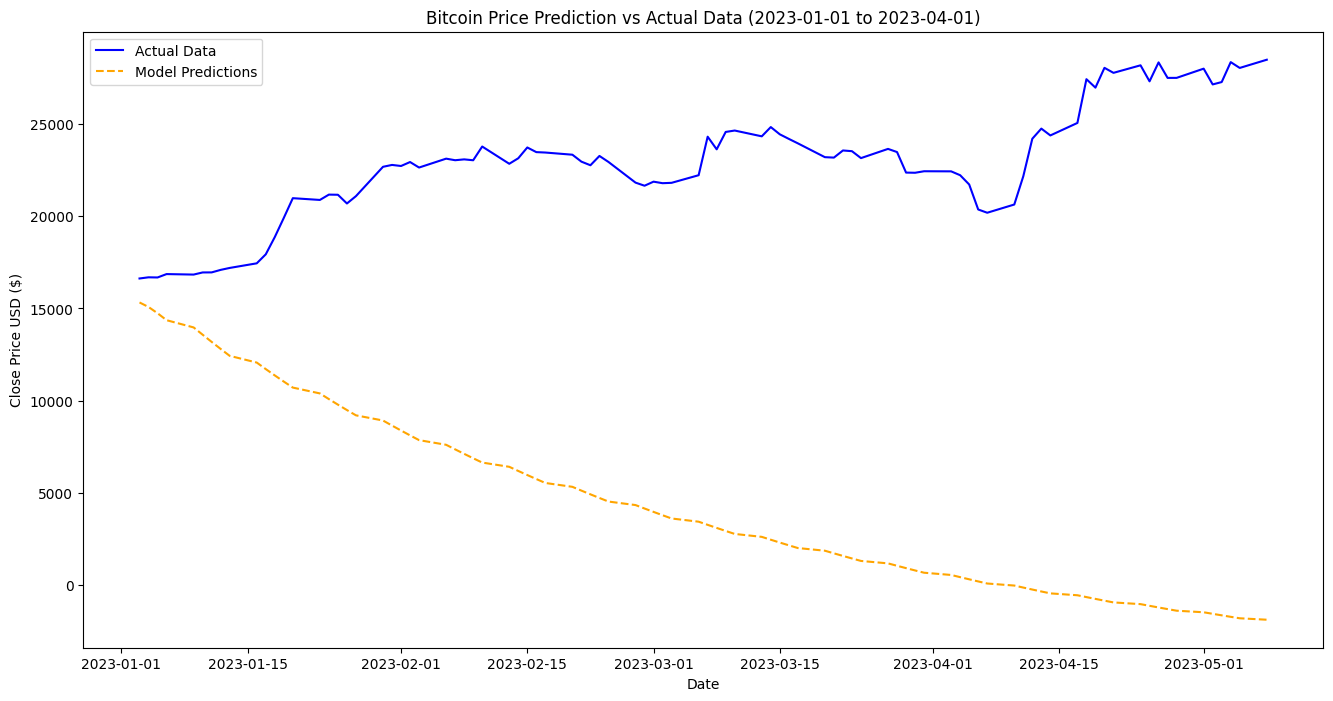

In [308]:
# Plot the predicted vs actual graph for the specified period
plt.figure(figsize=(16, 8))
plt.title('Bitcoin Price Prediction vs Actual Data (2023-01-01 to 2023-04-01)')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')

# Plotting actual data
plt.plot(future_dates, actual_data_2023['Close'][:], label='Actual Data', color='blue')

# Plotting model predictions
plt.plot(future_dates, future_predictions, label='Model Predictions', linestyle='dashed', color='orange')

plt.legend(loc='upper left')
plt.show()

Model Evaluation, prediction vs acutal price

In [309]:
# Calculate evaluation metrics for the plotted period
rmse_plot = np.sqrt(mean_squared_error(actual_data_2023['Close'][:], future_predictions))
mae_plot = mean_absolute_error(actual_data_2023['Close'][:], future_predictions)

# Calculate MAPE only if there are no zero values in the actual data
if not actual_data_2023['Close'][:].eq(0).any():
    mape_plot = np.mean(np.abs((actual_data_2023['Close'][:] - future_predictions.flatten()) / actual_data_2023['Close'][:])) * 100
else:
    mape_plot = np.nan

r2_plot = r2_score(actual_data_2023['Close'][:], future_predictions)

# Display the evaluation metrics for the plotted period
print(f'Root Mean Squared Error (RMSE): {rmse_plot:.2f}')
print(f'Mean Absolute Error (MAE): {mae_plot:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_plot:.2f}%')
print(f'R-squared (R2) Score: {r2_plot:.4f}')

Root Mean Squared Error (RMSE): 19922.17
Mean Absolute Error (MAE): 18387.37
Mean Absolute Percentage Error (MAPE): 77.30%
R-squared (R2) Score: -41.0515
